# 身長の伸び具合を個人差を含めて予測する
- 単純な単回帰で扱わないのは、身長の伸び具合は個人差があるはずなので
- y[i]（個人ごとの身長） = a[i]（個人ごとの傾き） * x(年齢) + b[i]
- a[i]（個人ごと傾き） = a0（共通部分）+ a_id(個人ごとのばらつき)
- b[i]（個人ごとの切片） = b0（共通部分） + b_id（個人ごとのばらつき）
- yとbは正規分布していると仮定する
- 階層とついてるのは、個人ごとのばらつきの値a_id, b_idを推定してから、その値を含めて身長yの値を推定しているため

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mstats
import pystan
%matplotlib inline

In [2]:
plt.style.use("ggplot")

In [3]:
df = pd.read_excel("./data/multilevel_modeling.xlsx")

In [4]:
# age: 年齢
# height: 身長

df.head()

,age,height,id
0,1,72.737927,1
1,3,85.694575,1
2,5,98.635829,1
3,8,117.302636,1
4,10,130.076144,1


In [5]:
df["id"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
      dtype=int64)

In [6]:
groups = df.groupby(df["id"])

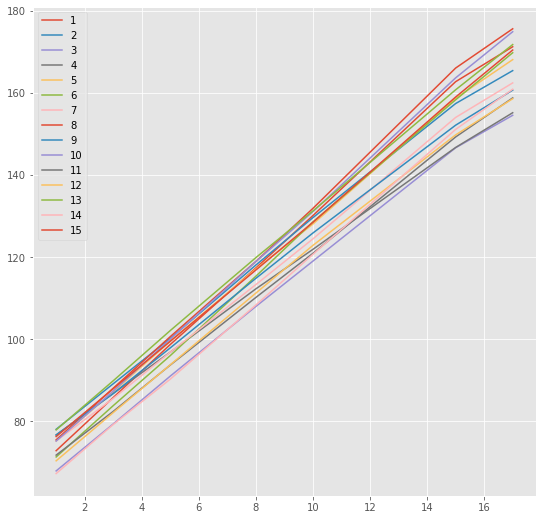

In [7]:
# idごとの年齢と身長の関係
# 人によって身長の伸び具合が違うのがわかる

plt.figure(figsize=(9,9))
for name, group in groups:
    plt.plot(group["age"],group["height"],label=name)
plt.legend()

In [8]:
# PyStanは書き方が特殊
# コメントで以下のようなブロックを書く必要がある
# ①dataブロック（観測したデータの入れ物）→
# ②パラメータのブロック→
#  ベルヌーイロジットののパラメータはa,bだけ
# ③統計モデルの（尤度関数）ブロック→
# ④事前分布
#  省略している。事前分布していなければ無条件兼事前分布が事前分布になる

# パラメータのs_a, s_b, s_Yは正規分布の標準偏差

# 階層ベイズモデルはtransformed parameters { でパラメータを組み合わせる

stan_model = """
data {
  int N;
  int N_id;
  real X[N];
  real Y[N];
  int<lower=1, upper=N_id> s_id[N];
}

parameters {
  real a0;
  real b0;
  real a_id[N_id];
  real b_id[N_id];
  real<lower=0> s_a;
  real<lower=0> s_b;
  real<lower=0> s_Y;
}

transformed parameters {
  real a[N_id];
  real b[N_id];
  for (n in 1:N_id){
    a[n] = a0 + a_id[n];
    b[n] = b0 + b_id[n];
  }
}

model {
  for (id in 1:N_id){
    a_id[id] ~ normal(0, s_a);
    b_id[id] ~ normal(0, s_b);
  }
  
  for (n in 1:N){
    Y[n] ~ normal(a[s_id[n]] * X[n] + b[s_id[n]], s_Y);
  }
}

"""

In [9]:
sm = pystan.StanModel(model_code=stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_086a333d9101221579c8f12b530c2084 NOW.


In [10]:
stan_data = {"N":df.shape[0], "N_id":15, "X":df["age"], "Y":df["height"], "s_id":df["id"]}

In [11]:
fit = sm.sampling(data = stan_data, iter=3000, warmup=1000, chains=3, seed=123)

In [12]:
fit

Inference for Stan model: anon_model_086a333d9101221579c8f12b530c2084.
3 chains, each with iter=3000; warmup=1000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=6000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a0         5.77  4.4e-3   0.12   5.54    5.7   5.77   5.85   5.99    685    1.0
b0        68.28    0.04   1.01   66.3  67.62  68.27  68.93  70.33    776    1.0
a_id[1]    0.46  4.4e-3   0.13   0.21   0.38   0.46   0.55   0.72    861    1.0
a_id[2]   -0.19  4.4e-3   0.13  -0.44  -0.28   -0.2  -0.11   0.06    840    1.0
a_id[3]   -0.29  4.4e-3   0.13  -0.54  -0.38   -0.3  -0.21  -0.05    844    1.0
a_id[4]    -0.8  4.4e-3   0.13  -1.05  -0.89   -0.8  -0.72  -0.55    825    1.0
a_id[5]    0.09  4.6e-3   0.13  -0.17 1.7e-3   0.08   0.17   0.35    799    1.0
a_id[6]    0.41  4.6e-3   0.13   0.16   0.32    0.4   0.49   0.66    771    1.0
a_id[7]   -0.21  4.4e-3   0.13  -0.46  -0.29  -0.22  -0.13   0.04    832    1.0
a_id[8]    

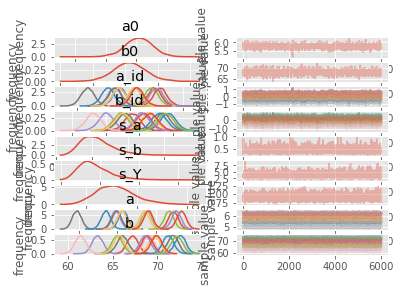

In [13]:
fig = fit.plot()

In [14]:
# ベイズ信頼区間を出すためにパラメータ取り出す

ms_a = fit.extract("a")["a"]
ms_b = fit.extract("b")["b"]

In [15]:
# ms_a[:,0]で出席番号1番の人だけの結果を出す

x = np.arange(18)
df_b = pd.DataFrame([])
for i in range(18):
    df_b[i] = ms_a[:,0] * x[i] + ms_b[:,0]

In [16]:
# 信頼区間計算

low_y50, high_y50 = mstats.mquantiles(df_b, [0.25, 0.75], axis=0)
low_y95, high_y95 = mstats.mquantiles(df_b, [0.025, 0.975], axis=0)

In [17]:
# 出席番号1番の人だけの結果を出す

df_0 = groups.get_group(1)

In [18]:
df_0.head()

,age,height,id
0,1,72.737927,1
1,3,85.694575,1
2,5,98.635829,1
3,8,117.302636,1
4,10,130.076144,1


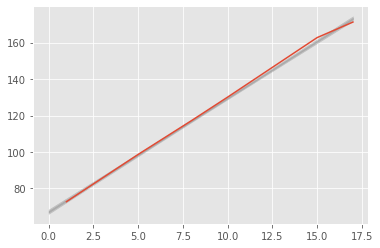

In [19]:
# ベイズ信頼区間を塗りつぶす
# 出席番号1の人の身長の推定はすごい綺麗に乗ってる
# これは共通部分の項があるため。共通部分は他のidのデータも使ってモデル作った。データの数が増えたので精度上がった
# 階層ベイズモデルはデータが少ない要素も共通部分によりうまく推定できるところがメリット

plt.plot(df_0["age"],df_0["height"])
plt.fill_between(x, low_y50, high_y50, alpha=0.6, color="darkgray")
plt.fill_between(x, low_y95, high_y95, alpha=0.3, color="gray")